In [1]:
# Essential
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg    
from PIL import Image
import cv2
from scipy import fftpack   

# Torch
import torchvision
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# We got SENet18 from here
import timm

In [2]:
# Import model architecture
m = timm.create_model('legacy_seresnet18', pretrained=True)

# Change first layer stride from 2 to 1
m.layer0[0].stride = (1, 1)

# Erase first max pooling layer
m.pool0 = nn.Identity()

# Change the last output to 4 classes with softmax
in_features = m.last_linear.in_features
m.last_linear = nn.Linear(in_features, 4)
m.softmax = nn.Softmax(dim=1)
m.eval()

SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
  )
  (pool0): Identity()
  (layer1): Sequential(
    (0): SEResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se_module): SEModule(
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
        (sigmoid): Sigmoid()
      )
    )
    (1): SEResNetBlock(
      (conv1): Con

In [3]:
cover_path='alaska2/Cover'
jmd_path='alaska2/JMiPOD'
jwd_path='alaska2/JUNIWARD'
urd_path='alaska2/UERD'

In [4]:
cover_images_path=[]
for a,b,c in os.walk(cover_path):
    for f in c:
        cover_images_path.append(os.path.join(a,f))
len(cover_images_path)

75000

In [5]:
jmd_images_path=[]
for a,b,c in os.walk(jmd_path):
    for f in c:
        jmd_images_path.append(os.path.join(a,f))
len(jmd_images_path)

75000

In [6]:
jwd_images_path=[]
for a,b,c in os.walk(jwd_path):
    for f in c:
        jwd_images_path.append(os.path.join(a,f))
len(jwd_images_path)

75000

In [7]:
urd_images_path=[]
for a,b,c in os.walk(urd_path):
    for f in c:
        urd_images_path.append(os.path.join(a,f))
len(urd_images_path)

75000

In [8]:
train_paths=np.concatenate([cover_images_path[:2000],
                            jmd_images_path[:2000],
                            jwd_images_path[:2000],
                            urd_images_path[:2000]])
len(train_paths)

8000

In [20]:
test_paths=np.concatenate([cover_images_path[4000:4010]])
test_labels=np.array([0]*10)

In [9]:
train_labels=np.array(
    [0] * 2000 + 
    [1] * 2000 + 
    [2] * 2000 + 
    [3] * 2000)
len(train_labels)

8000

In [10]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, 
                                                                        train_labels, 
                                                                        test_size=0.2,
                                                                        shuffle=True)
print('Train len: {}\nValid len: {}'.format(len(train_paths),len(valid_paths)))

Train len: 6400
Valid len: 1600


In [11]:
def decode_image(filename, label=None, image_size=(224, 224)):
    
    image = Image.open(filename).convert("YCbCr")
    image = transforms.Resize(image_size)(image)
    image = transforms.ToTensor()(image)
    image = image.float()/255.0
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = normalize(image)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  
        transforms.RandomVerticalFlip(),    
        transforms.RandomRotation((90,90)),
        # transforms.RandomCrop((512, 512)),        
    ])

    image = transform(image)

    if label is None:
        return image
    else:
        return image, label

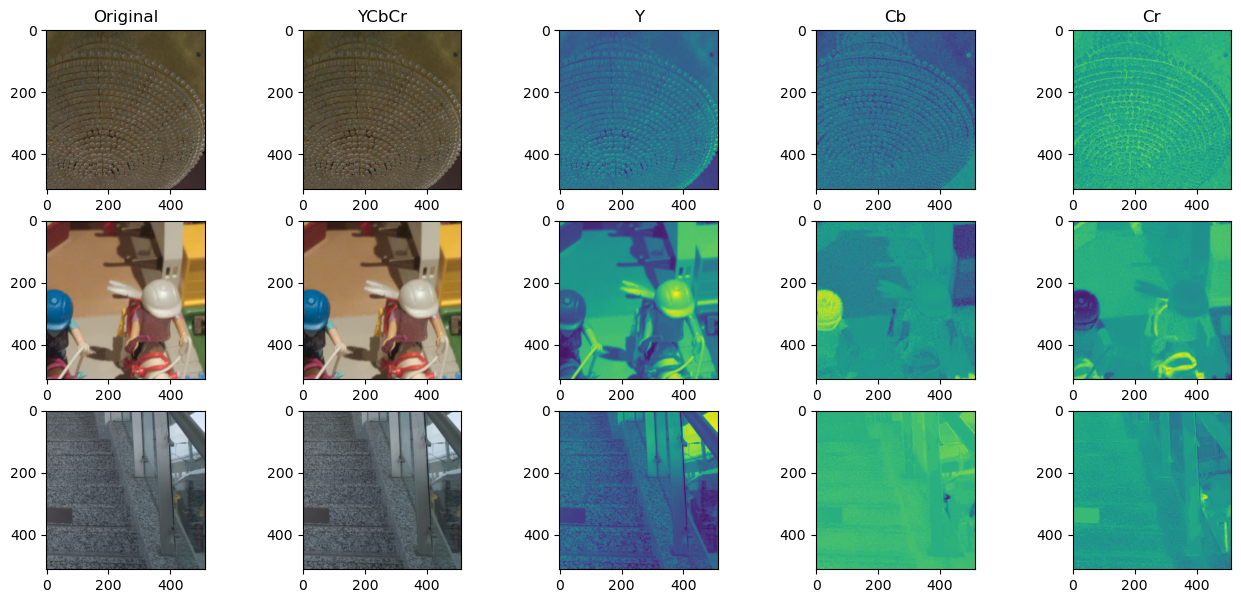

In [33]:
fig, ax = plt.subplots(3, 5, figsize=(16, 7))

for index, path in enumerate(cover_images_path[163:166]):
    
    original_image = Image.open(path)
    ycbcr_image = original_image.convert('YCbCr')
    (y, cb, cr) = ycbcr_image.split()
    
    ax[index, 0].imshow(original_image)
    ax[index, 1].imshow(ycbcr_image)
    ax[index, 2].imshow(y)
    ax[index, 3].imshow(cb)
    ax[index, 4].imshow(cr)

    if index==0:
        ax[index, 0].set_title('Original', fontsize=12)
        ax[index, 1].set_title('YCbCr', fontsize=12)
        ax[index, 2].set_title('Y', fontsize=12)
        ax[index, 3].set_title('Cb', fontsize=12)
        ax[index, 4].set_title('Cr', fontsize=12)

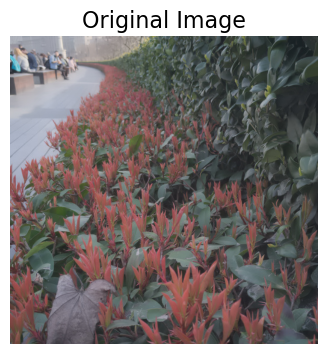

In [31]:
image = mpimg.imread(cover_images_path[222])

plt.figure(figsize = (4, 4))
plt.imshow(image)
plt.title('Original Image', fontsize=16)
plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'An 8x8 DCT block')

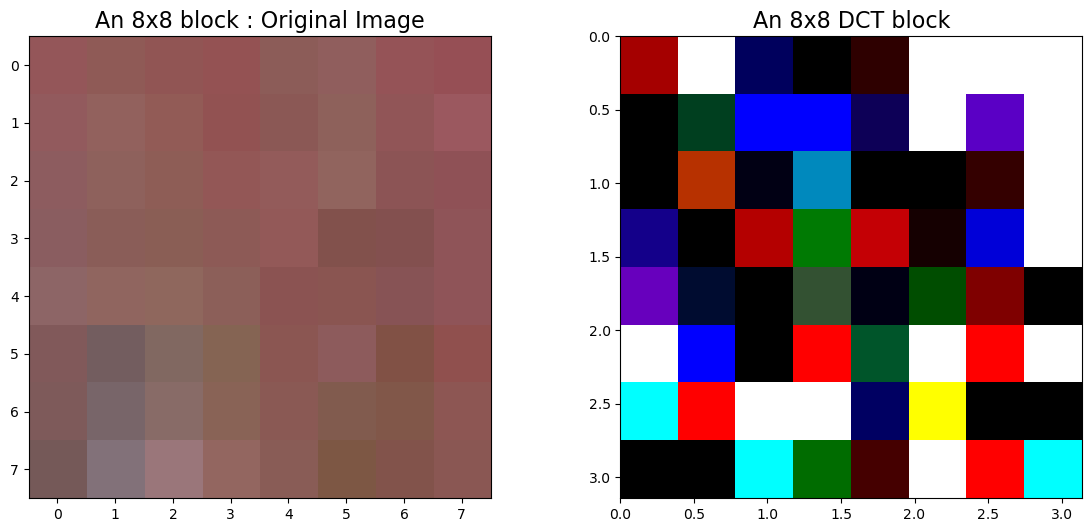

In [34]:
# Define 2D DCT
def dct2(a):
    # Return the Discrete Cosine Transform of arbitrary type sequence x.
    return fftpack.dct(fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho')

# Perform a blockwise DCT
imsize = image.shape
dct = np.zeros(imsize)

# Do 8x8 DCT on image (in-place)
for i in np.r_[:imsize[0]:8]:
    for j in np.r_[:imsize[1]:8]:
        dct[i:(i+8),j:(j+8)] = dct2( image[i:(i+8),j:(j+8)] )
        

pos = 155   

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Display original
ax1.imshow(image[pos:pos+8,pos:pos+8],cmap='gray')
ax1.set_title("An 8x8 block : Original Image", fontsize=16)

# Display the dct of that block
ax2.imshow(dct[pos:pos+8,pos:pos+8],cmap='gray',vmax= np.max(dct)*0.01,vmin = 0, extent=[0,np.pi,np.pi,0])
ax2.set_title("An 8x8 DCT block", fontsize = 16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


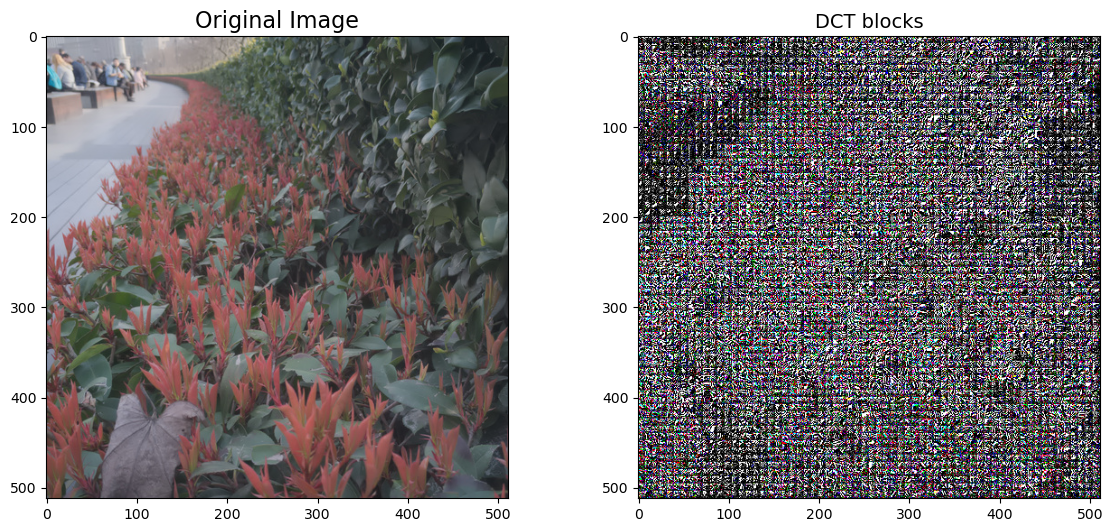

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Original image
ax1.imshow(image);
ax1.set_title("Original Image", fontsize = 16);

# DCT Blocks
ax2.imshow(dct,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
ax2.set_title("DCT blocks", fontsize = 14);

In [12]:
EPOCHS = 1
BATCH_SIZE = 16

class CustomDataset(Dataset):
    def __init__(self, paths, labels=None, image_size=(224, 224), transform=None):
        self.paths = paths
        self.labels = labels
        self.image_size = image_size
        self.transform = transform
    
    def __getitem__(self, index):
        path = self.paths[index]
        label = self.labels[index] if self.labels is not None else None
        
        image = decode_image(path)
        image = Image.open(path).convert("YCbCr")  
        image = data_augment(image)
        
        if self.transform is not None:
            image = self.transform(image)
        if label is None:
            return image
        else:
            return image, label
    
    def __len__(self):
        return len(self.paths)

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CustomDataset(train_paths, train_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = CustomDataset(valid_paths, valid_labels, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

In [21]:
test_dataset=CustomDataset(test_paths, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=10)

In [13]:
dataset_size = len(train_dataset)
print("Train dataset size:", dataset_size)

batch_count = len(train_loader)
print("Train loader size (batch count):", batch_count)

Train dataset size: 6400
Train loader size (batch count): 400


In [14]:
for param in m.parameters():
    param.requires_grad = True

In [28]:
device = torch.device("cuda")
learning_rate=0.001
weight_decay=0.00001

criterion = nn.CrossEntropyLoss() 
optimizer = optim.AdamW(m.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max',
                                                           patience=1, verbose=True, factor=0.4)

for epoch in range(EPOCHS):
    m = m.to(device)
    m.train()
    total_correct_train = 0
    total_samples_train = 0
    for step, (images, labels) in enumerate(train_loader):  
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = m(images)
        
        labels = labels.long()
        loss = criterion(outputs, labels)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_correct_train += (predicted == labels).sum().item()
        total_samples_train += labels.size(0)
        accuracy_train = total_correct_train / total_samples_train

        print(f'Epoch [{epoch+1}/{EPOCHS}], Step: {step+1}/{len(train_loader)}, Loss: {loss.item():.4f}, Accuracy: {accuracy_train:.4f}')

    m.eval()  
    with torch.no_grad():
        valid_loss = 0.0
        total_correct = 0
        total_samples = 0
        for images, labels in valid_loader:
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = m(images)
            
            labels = labels.long()
            
            valid_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
        valid_loss /= len(valid_loader)
        accuracy = total_correct / total_samples
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}')
    
    try:
        torch.save(m.state_dict(), 'seresnet18_trained-e{}.pth'.format(epoch+1))
    except Exception as e:
        print("Error saving model at epoch", epoch+1, ":", e)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.14 GiB is allocated by PyTorch, and 478.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF